# Lecture 7: Spiral classification

Notebook adapted from [Deep Learning (with PyTorch)](https://github.com/Atcold/pytorch-Deep-Learning) by Alfredo Canziani. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
# Plot functions
import matplotlib.pyplot as plt
from IPython import display
plt.rc('figure', figsize=(8, 8))

def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')
    
def plot_model(X, y, model):  
    model.cpu()
    
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()

    if Z.dim() > 1 and Z.size(1) > 1:
        Z = torch.argmax(Z, dim=1)
    else:
        Z = (Z > 0.5).float()

    Z = Z.reshape(xx.shape).numpy()
    
    plt.contourf(xx, yy, Z, alpha=0.3)
    plot_data(X, y)

In [19]:
# Setup
seed = 12345
torch.manual_seed(seed)

N = 200  # num_samples_per_class
D = 2    # dimensions
C = 4    # num_classes

In [20]:
# Generate spiral data
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    inner_var = torch.linspace(
        (2 * np.pi / C) * (c),
        (2 * np.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.5
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            np.cos(inner_var[index]), np.sin(inner_var[index])
        ))
        y[ix] = c
        index += 1

In [21]:
X.shape, y.shape

(torch.Size([800, 2]), torch.Size([800]))

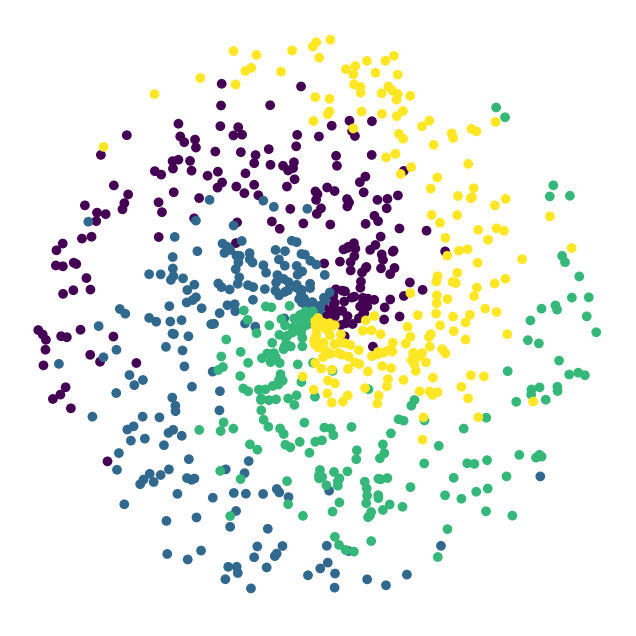

In [22]:
plot_data(X, y)

### Linear model

[EPOCH]: 1999, [LOSS]: 0.635055, [ACCURACY]: 0.477


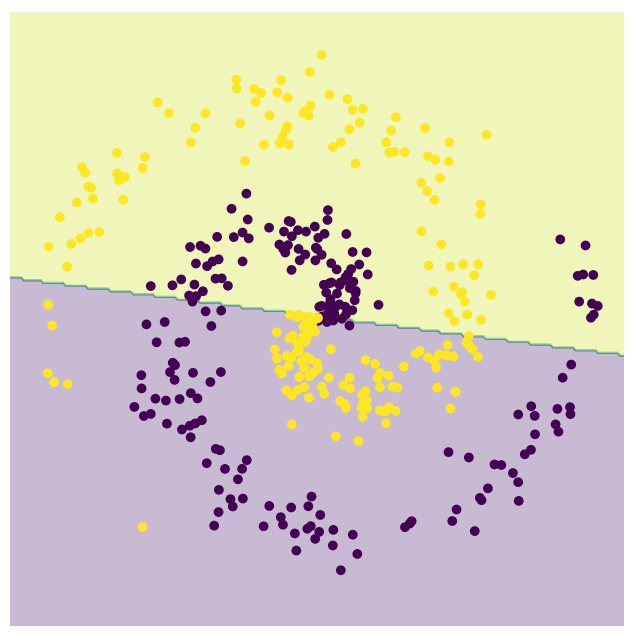

In [43]:
model = torch.nn.Sequential(
    torch.nn.Linear(D, 1),
    torch.nn.Sigmoid()
)

model.to(device)  
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters()) 

# Training
for t in range(2000):
    y_pred = model(X)
    
    loss = criterion(y_pred.squeeze(), y.float())
    predicted = (y_pred > 0.5).float().squeeze()
    acc = (y == predicted).sum().float() / len(y)
    
    if t % 25 == 0:
        plt.clf()
        plot_model(X, y, model)
        model.to(device)
        display.display(plt.gcf())
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
        display.clear_output(wait=True)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))

[EPOCH]: 1999, [LOSS]: -0.407863, [ACCURACY]: 0.435


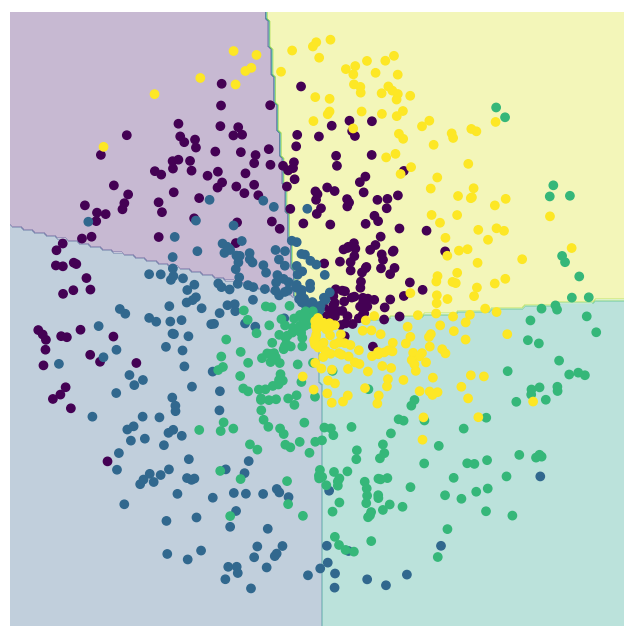

In [23]:
# Multiclass classification (C > 2)
model = torch.nn.Sequential(
    torch.nn.Linear(D, C),
    torch.nn.Softmax(dim=1)
)

model.to(device)  
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters()) 

# Training
for t in range(2000):
    y_pred = model(X)
    
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    
    if t % 25 == 0:
        plt.clf()
        plot_model(X, y, model)
        model.to(device)
        display.display(plt.gcf())
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
        display.clear_output(wait=True)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))

### MLP

[EPOCH]: 1999, [LOSS]: -0.905994, [ACCURACY]: 0.921


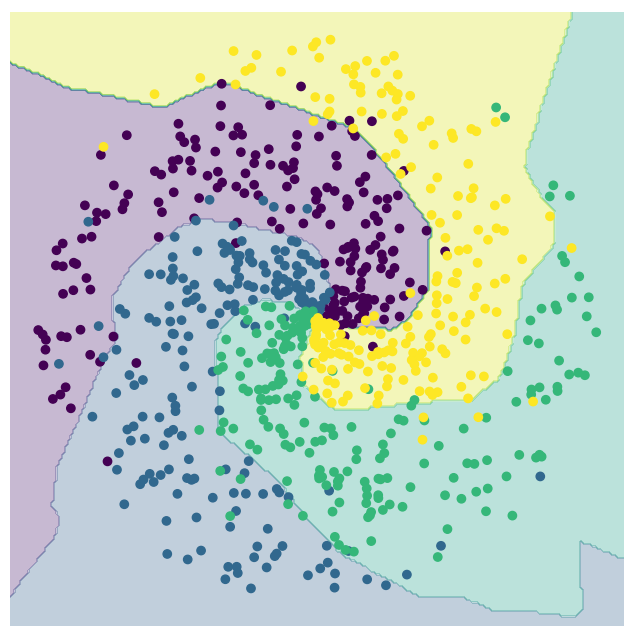

In [24]:
# To show and discuss:
# - Effect of the non-linearity
# - Effect of H 
# - Effect of the number of layers 
# - Effect of the activation function
# - Multi-class classification

H = 50

model = torch.nn.Sequential(
    torch.nn.Linear(D, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, C),
    torch.nn.Softmax(dim=1)
)

model.to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters()) 

for t in range(2000):
    y_pred = model(X)
    
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    
    if t % 25 == 0:
        plt.clf()
        plot_model(X, y, model)
        model.to(device)
        display.display(plt.gcf())
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
        display.clear_output(wait=True)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))